# Import & Credits
Credits to: NielsRogge: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/DETR/Fine_tuning_DetrForObjectDetection_on_custom_dataset_(balloon).ipynb

Algorithm Source: https://huggingface.co/docs/transformers/v4.39.2/en/model_doc/detr#transformers.DetrForObjectDetection

In [1]:
import torch, torchvision
import sys
import zipfile
import os

import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from pytorch_lightning import Trainer
from PIL import Image, ImageDraw
from git import Repo
from urllib.request import urlretrieve
from transformers import DetrImageProcessor, DetrForObjectDetection
from torch.utils.data import DataLoader
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

datapath = "../data/extracted_data/"

# Download and Extract Data, convert Format and Load
Set x = True if the data should be loaded, extracted and converted

In [2]:
x = False
if x:
	# Download Data, in VIA format
	urlretrieve("https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip","data/zipfile/balloon_dataset.zip")
	# unzip
	with zipfile.ZipFile("data/zipfile/balloon_dataset.zip", "r") as z:
		z.extractall(datapath)

## Convert from VIA to COCO format

In [3]:
if x:
	# clone repo to data and add the path to the system, would rais an exception if the repo is already loaded in. 
	try:
		Repo.clone_from("https://github.com/woctezuma/VIA2COCO", "data/conversion/")
	except:
		pass
	# append conversion directory to path to fix a module laod error from the cloned repo
	sys.path.append(os.path.join(os.getcwd(), "data/conversion/"))

	# only used in this block
	from data.conversion import convert as via2coco

	data_path = os.path.join(datapath, 'balloon/')

	first_class_index = 0

	for keyword in ['train', 'val']:

		input_dir = data_path + keyword + '/'
		input_json = input_dir + 'via_region_data.json'
		categories = ['balloon']
		super_categories = ['N/A']
		output_json = input_dir + 'custom_' + keyword + '.json'

		print('Converting {} from VIA format to COCO format'.format(input_json))

		coco_dict = via2coco.convert(
			imgdir=input_dir,
			annpath=input_json,
			categories=categories,
			super_categories=super_categories,
			output_file_name=output_json,
			first_class_index=first_class_index,
  		)



## Create Datasets + Dataloaders (Pytoch)

### Define Funtions

In [4]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, processor, train=True):
        ann_file = os.path.join(img_folder, "custom_train.json" if train else "custom_val.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

def collate_fn(batch):
	pixel_values = [item[0] for item in batch]
	encoding = processor.pad(pixel_values, return_tensors="pt")
	labels = [item[1] for item in batch]
	batch = {}
	batch['pixel_values'] = encoding['pixel_values']
	batch['pixel_mask'] = encoding['pixel_mask']
	batch['labels'] = labels
	return batch

### create Datasets

In [5]:
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

train_folder = os.path.join(datapath, "balloon/train")
val_folder = os.path.join(datapath, "balloon/val")

train_dataset = CocoDetection(img_folder=train_folder, processor=processor)
val_dataset = CocoDetection(img_folder=val_folder, processor=processor, train=False)

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 61
Number of validation examples: 13


### Visualize imported Data

Image n°37


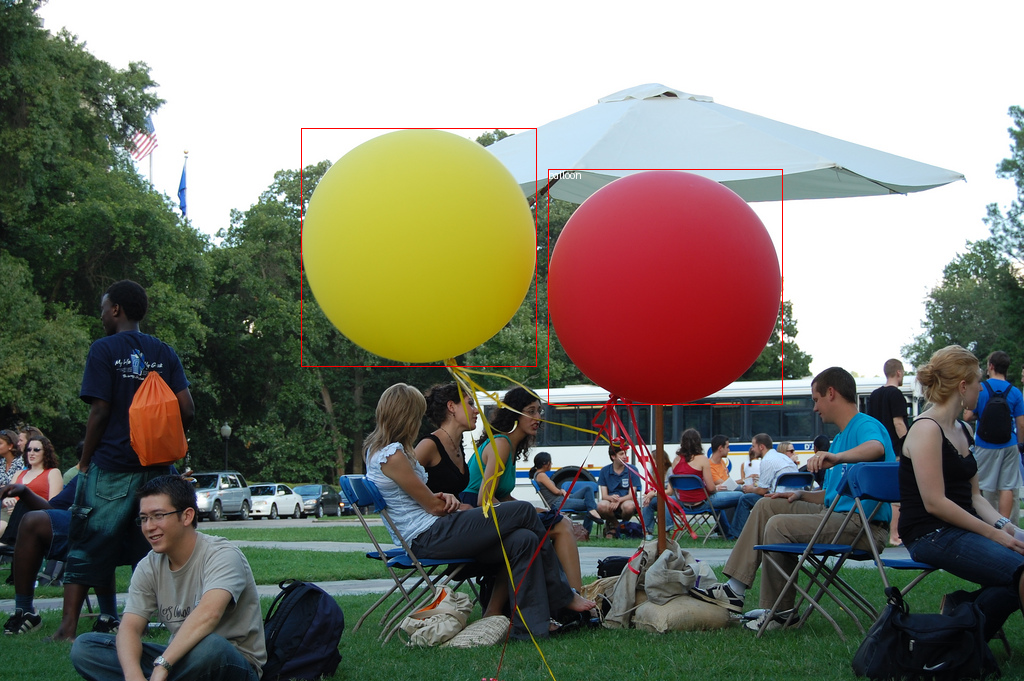

In [7]:
# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(datapath, 'balloon/train', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
	box = annotation['bbox']
	class_idx = annotation['category_id']
	x,y,w,h = tuple(box)
	draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
	draw.text((x, y), id2label[class_idx], fill='white')

image

### create Dataloaders

In [8]:
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2)
batch = next(iter(train_dataloader))

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


### looking into the batches

In [9]:
print("Single Batch, Keys: {}".format(batch.keys()))
pixel_values, target = train_dataset[0]
print("image size: {}".format(pixel_values.shape))
print("Information aside pixel values: {}".format(target))

Single Batch, Keys: dict_keys(['pixel_values', 'pixel_mask', 'labels'])
image size: torch.Size([3, 800, 1066])
Information aside pixel values: {'size': tensor([ 800, 1066]), 'image_id': tensor([0]), 'class_labels': tensor([0]), 'boxes': tensor([[0.5955, 0.5811, 0.2202, 0.3561]]), 'area': tensor([3681.5083]), 'iscrowd': tensor([0]), 'orig_size': tensor([1536, 2048])}


# Train with Pytorch Lightning

## Trainingclass, Define DETR algorithm

In [10]:
class Detr(pl.LightningModule):
     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         # we specify the "no_timm" variant here to not rely on the timm library
         # for the convolutional backbone
         self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                             revision="no_timm",
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.save_hyperparameters()
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

## assign and verify the model outputs

In [11]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

y = False
if y:
	outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

	print("")
	print("logits in the shape of, batch_size, num_queries, num_classes + 1 (noclasslabel) {}".format(outputs.logits.shape))

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training

In [12]:
z = False

if z:
	max_steps = 300

	# Pytorch lightning Trainer
	trainer = Trainer(max_steps=max_steps, gradient_clip_val=0.1)
	trainer.fit(model)

## save & load Modelcheckpoints

In [22]:
# will be done together with the logger, dont wanna load to the huggingface hub...
# as long as this isnt integrated, the evaluation cant take place with the trained model

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu" # as long as the model isnt loaded from here

# Evaluation

## Define Conversion functions

In [20]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

## Evaluate

In [21]:
# initialize evaluator with ground truth (gt)
evaluator = CocoEvaluator(coco_gt=val_dataset.coco, iou_types=["bbox"])

print("Running evaluation...")
for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    # turn into a list of dictionaries (one item for each example in the batch)
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0)

    # provide to metric
    # metric expects a list of dictionaries, each item
    # containing image_id, category_id, bbox and score keys
    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...


  0%|          | 0/7 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.036
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.046
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.068
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.114
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.472
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.396
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.561
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

torch.Size([1, 3, 1066, 800])
Outputs: odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'encoder_last_hidden_state'])


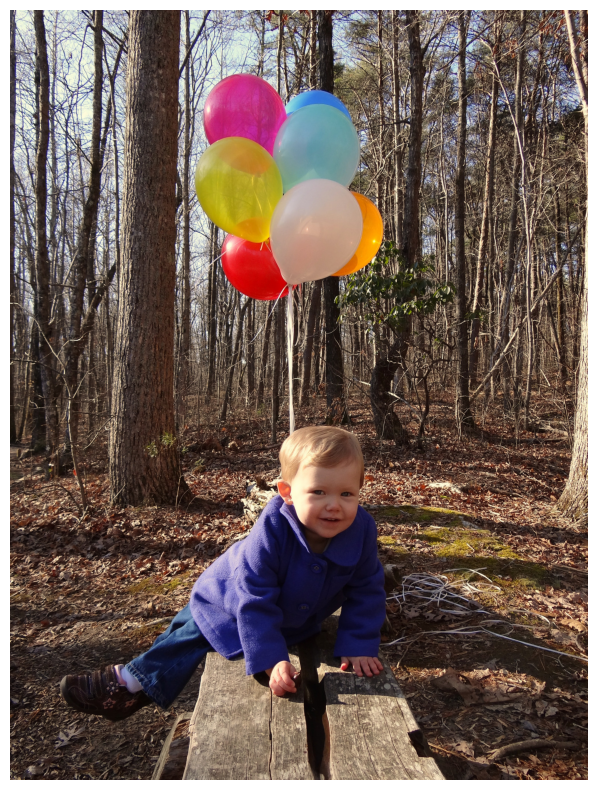

In [25]:
#We can use the image_id in target to know which image it is
pixel_values, target = val_dataset[1]
pixel_values = pixel_values.unsqueeze(0).to(device)
print(pixel_values.shape)
with torch.no_grad():
  # forward pass to get class logits and bounding boxes
  outputs = model(pixel_values=pixel_values, pixel_mask=None)
print("Outputs:", outputs.keys())
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    
# load image based on ID
image_id = target['image_id'].item()
image = val_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(datapath, 'balloon/val', image['file_name']))

# postprocess model outputs
width, height = image.size
postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                target_sizes=[(height, width)],
                                                                threshold=0.9)
results = postprocessed_outputs[0]
plot_results(image, results['scores'], results['labels'], results['boxes'])